# Introduction to RNNs, LSTMs, and Attention in Healthcare

## 1. Setup and Installation

In [2]:
# Install required packages (run this cell)
!pip install numpy pandas matplotlib seaborn scikit-learn torch tqdm

## 2. Introduction
> Welcome!

> In this notebook, we will explore Recurrent Neural Networks (RNNs), Long Short-Term Memory (LSTM) networks, and the concept of attention in sequence modeling.

> We will use a real-world dataset, build models, visualize their behavior, and see how attention can improve performance.

## 3. Data Download and Exploration

> For demonstration, we’ll use a public healthcare time series dataset (a subset of the PhysioNet MIMIC-III dataset).

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import zipfile
import os
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import time

def download_physionet_data():
    base = "https://physionet.org/files/challenge-2012/1.0.0/"
    files = ["set-a.zip", "Outcomes-a.txt"]

    os.makedirs("physionet_data", exist_ok=True)

    for fname in files:
        dest = f"physionet_data/{fname}"
        if os.path.exists(dest) and os.path.getsize(dest) > 1_000:
            continue
        print(f"Downloading {fname} …")
        r = requests.get(base + fname, timeout=30)
        r.raise_for_status()

        with open(dest, "wb") as f:
            f.write(r.content)

        if fname.endswith(".zip"):
            with zipfile.ZipFile(dest) as zf:
                zf.extractall("physionet_data")
            print(f"  extracted {fname}")

def hhmm_to_hours(t):
    h, m = map(int, t.split(':'))
    return h + m/60

def load_physionet_data():
    data_files = []
    set_path = f'physionet_data/set-a'
    if os.path.exists(set_path):
        for file in os.listdir(set_path):
            if file.endswith('.txt'):
                data_files.append(os.path.join(set_path, file))
    
    if not data_files:
        print("No data files found. Please run download_physionet_data() first.")
        return None
    
    print(f"Found {len(data_files)} patient files")
    
    all_patients = []
    outcomes = {}
    
    outcomes_file = 'physionet_data/Outcomes-a.txt'
    if os.path.exists(outcomes_file):
        print("Loading outcomes file...")
        with open(outcomes_file, 'r') as f:
            lines = f.readlines()
            for line in lines[1:]:
                parts = line.strip().split(',')
                if len(parts) >= 6:
                    patient_id = parts[0]
                    outcome = int(parts[5])
                    outcomes[patient_id] = outcome
    
    vital_signs = ['HR', 'NISysABP', 'NIDiasABP', 'Temp', 'RespRate']
    metadata_params = ['RecordID', 'Age', 'Gender', 'Height', 'ICUType', 'Weight']
    
    processed_count = 0
    for file_path in data_files:
        patient_id = os.path.basename(file_path).replace('.txt', '')
        
        try:
            df_patient = pd.read_csv(file_path, header=0)
            
            df_patient = df_patient[~df_patient['Parameter'].isin(metadata_params)]
            
            df_patient['Time_hours'] = df_patient['Time'].apply(hhmm_to_hours)
            
            df_patient['Value'] = pd.to_numeric(df_patient['Value'], errors='coerce')
            df_patient = df_patient.dropna(subset=['Value', 'Time_hours'])
            
            if len(df_patient) == 0:
                continue
            
            df_patient['hour'] = df_patient['Time_hours'].astype(int)
            
            df_hourly = (
                df_patient
                .groupby(['hour', 'Parameter'])['Value']
                .mean()
                .reset_index()
                .pivot(index='hour', columns='Parameter', values='Value')
            )
            
            available_signs = [col for col in vital_signs if col in df_hourly.columns]
            
            if len(available_signs) >= 2:
                df_hourly = df_hourly[available_signs].loc[:23]
                
                df_hourly = df_hourly.ffill().bfill()
                
                non_nan_counts = df_hourly.notna().sum()
                if non_nan_counts.max() >= 2:
                    if len(df_hourly) < 24:
                        missing_hours = 24 - len(df_hourly)
                        for i in range(missing_hours):
                            df_hourly.loc[len(df_hourly)] = df_hourly.iloc[-1]
                    
                    patient_dict = {'patient_id': patient_id}
                    for sign in available_signs:
                        if sign in df_hourly.columns:
                            patient_dict[sign] = df_hourly[sign].values
                    
                    if patient_id in outcomes:
                        patient_dict['outcome'] = outcomes[patient_id]
                    else:
                        patient_dict['outcome'] = 0
                    
                    all_patients.append(patient_dict)
                    processed_count += 1
                        
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
            continue
    
    print(f"Successfully processed {processed_count} patients")
    return pd.DataFrame(all_patients)

print("Downloading PhysioNet Challenge 2012 dataset...")
download_physionet_data()
df = load_physionet_data()

print(f"Loaded {len(df)} patients with time series data")
print(f"Columns: {list(df.columns)}")
print("\nSample of first patient's data:")
if len(df) > 0:
    print(f"Patient ID: {df.iloc[0]['patient_id']}")
    print(f"HR values (first 10): {df.iloc[0]['HR'][:10]}")
    print(f"NISysABP values (first 10): {df.iloc[0]['NISysABP'][:10]}")
    print(f"Outcome: {df.iloc[0]['outcome']}")

df.head()

  extracted set-a.zip
Found 4000 patient files
Loading outcomes file...
Successfully processed 3928 patients
Loaded 3928 patients with time series data
Columns: ['patient_id', 'HR', 'NISysABP', 'NIDiasABP', 'Temp', 'RespRate', 'outcome']

Sample of first patient's data:
Patient ID: 132539
HR values (first 10): [75. 60. 62. 80. 74. 73. 64. 64. 66. 61.]
NISysABP values (first 10): [152. 137. 123. 114. 114. 110. 107. 102. 114. 109.]
Outcome: 0


,patient_id,HR,NISysABP,NIDiasABP,Temp,RespRate,outcome
0,132539,"[75.0, 60.0, 62.0, 80.0, 74.0, 73.0, 64.0, 64....","[152.0, 137.0, 123.0, 114.0, 114.0, 110.0, 107...","[61.5, 62.0, 52.0, 52.0, 52.0, 45.0, 49.0, 56....","[35.35, 35.35, 35.35, 37.8, 37.8, 37.8, 38.1, ...","[19.0, 18.0, 19.0, 20.0, 20.0, 17.0, 15.0, 14....",0
1,132540,"[88.0, 88.0, 88.0, 88.0, 88.0, 88.0, 88.0, 88....","[105.33333333333333, 105.33333333333333, 105.3...","[54.333333333333336, 54.333333333333336, 54.33...","[34.88, 34.88, 35.4, 35.9, 36.7, 37.2, 37.4, 3...",NaN,0
2,132541,"[89.0, 96.0, 91.5, 86.0, 87.0, 94.5, 113.0, 95...","[132.0, 137.0, 135.5, 125.0, 134.0, 144.0, 138...","[83.5, 89.0, 85.5, 75.0, 72.0, 83.5, 79.0, 86....","[37.8, 37.8, 37.2, 37.2, 37.2, 37.2, 39.0, 39....",NaN,0
3,132543,"[76.33333333333333, 80.75, 75.33333333333333, ...","[127.66666666666667, 125.5, 125.66666666666667...","[65.0, 70.25, 71.0, 70.0, 68.0, 74.0, 61.0, 63...","[36.3, 36.3, 36.3, 36.4, 36.4, 36.4, 36.4, 36....","[18.0, 17.571428571428573, 15.666666666666666,...",0
4,132545,"[88.5, 94.0, 87.0, 82.0, 84.0, 86.0, 82.0, 83....","[145.0, 151.0, 130.0, 119.0, 139.3333333333333...","[45.5, 29.0, 44.0, 36.0, 41.0, 41.0, 34.0, 96....","[37.8, 37.8, 35.8, 35.8, 36.9, 37.0, 37.2, 37....","[24.0, 26.0, 20.0, 19.0, 20.0, 18.0, 17.0, 21....",0


## 4. Data Visualization

C:\Users\Matt\AppData\Local\Temp\ipykernel_14604\2638330763.py:71: RuntimeWarning: Mean of empty slice
  sign: df[sign].apply(lambda s: np.nanmean(s) if isinstance(s, (list,np.ndarray)) else np.nan)


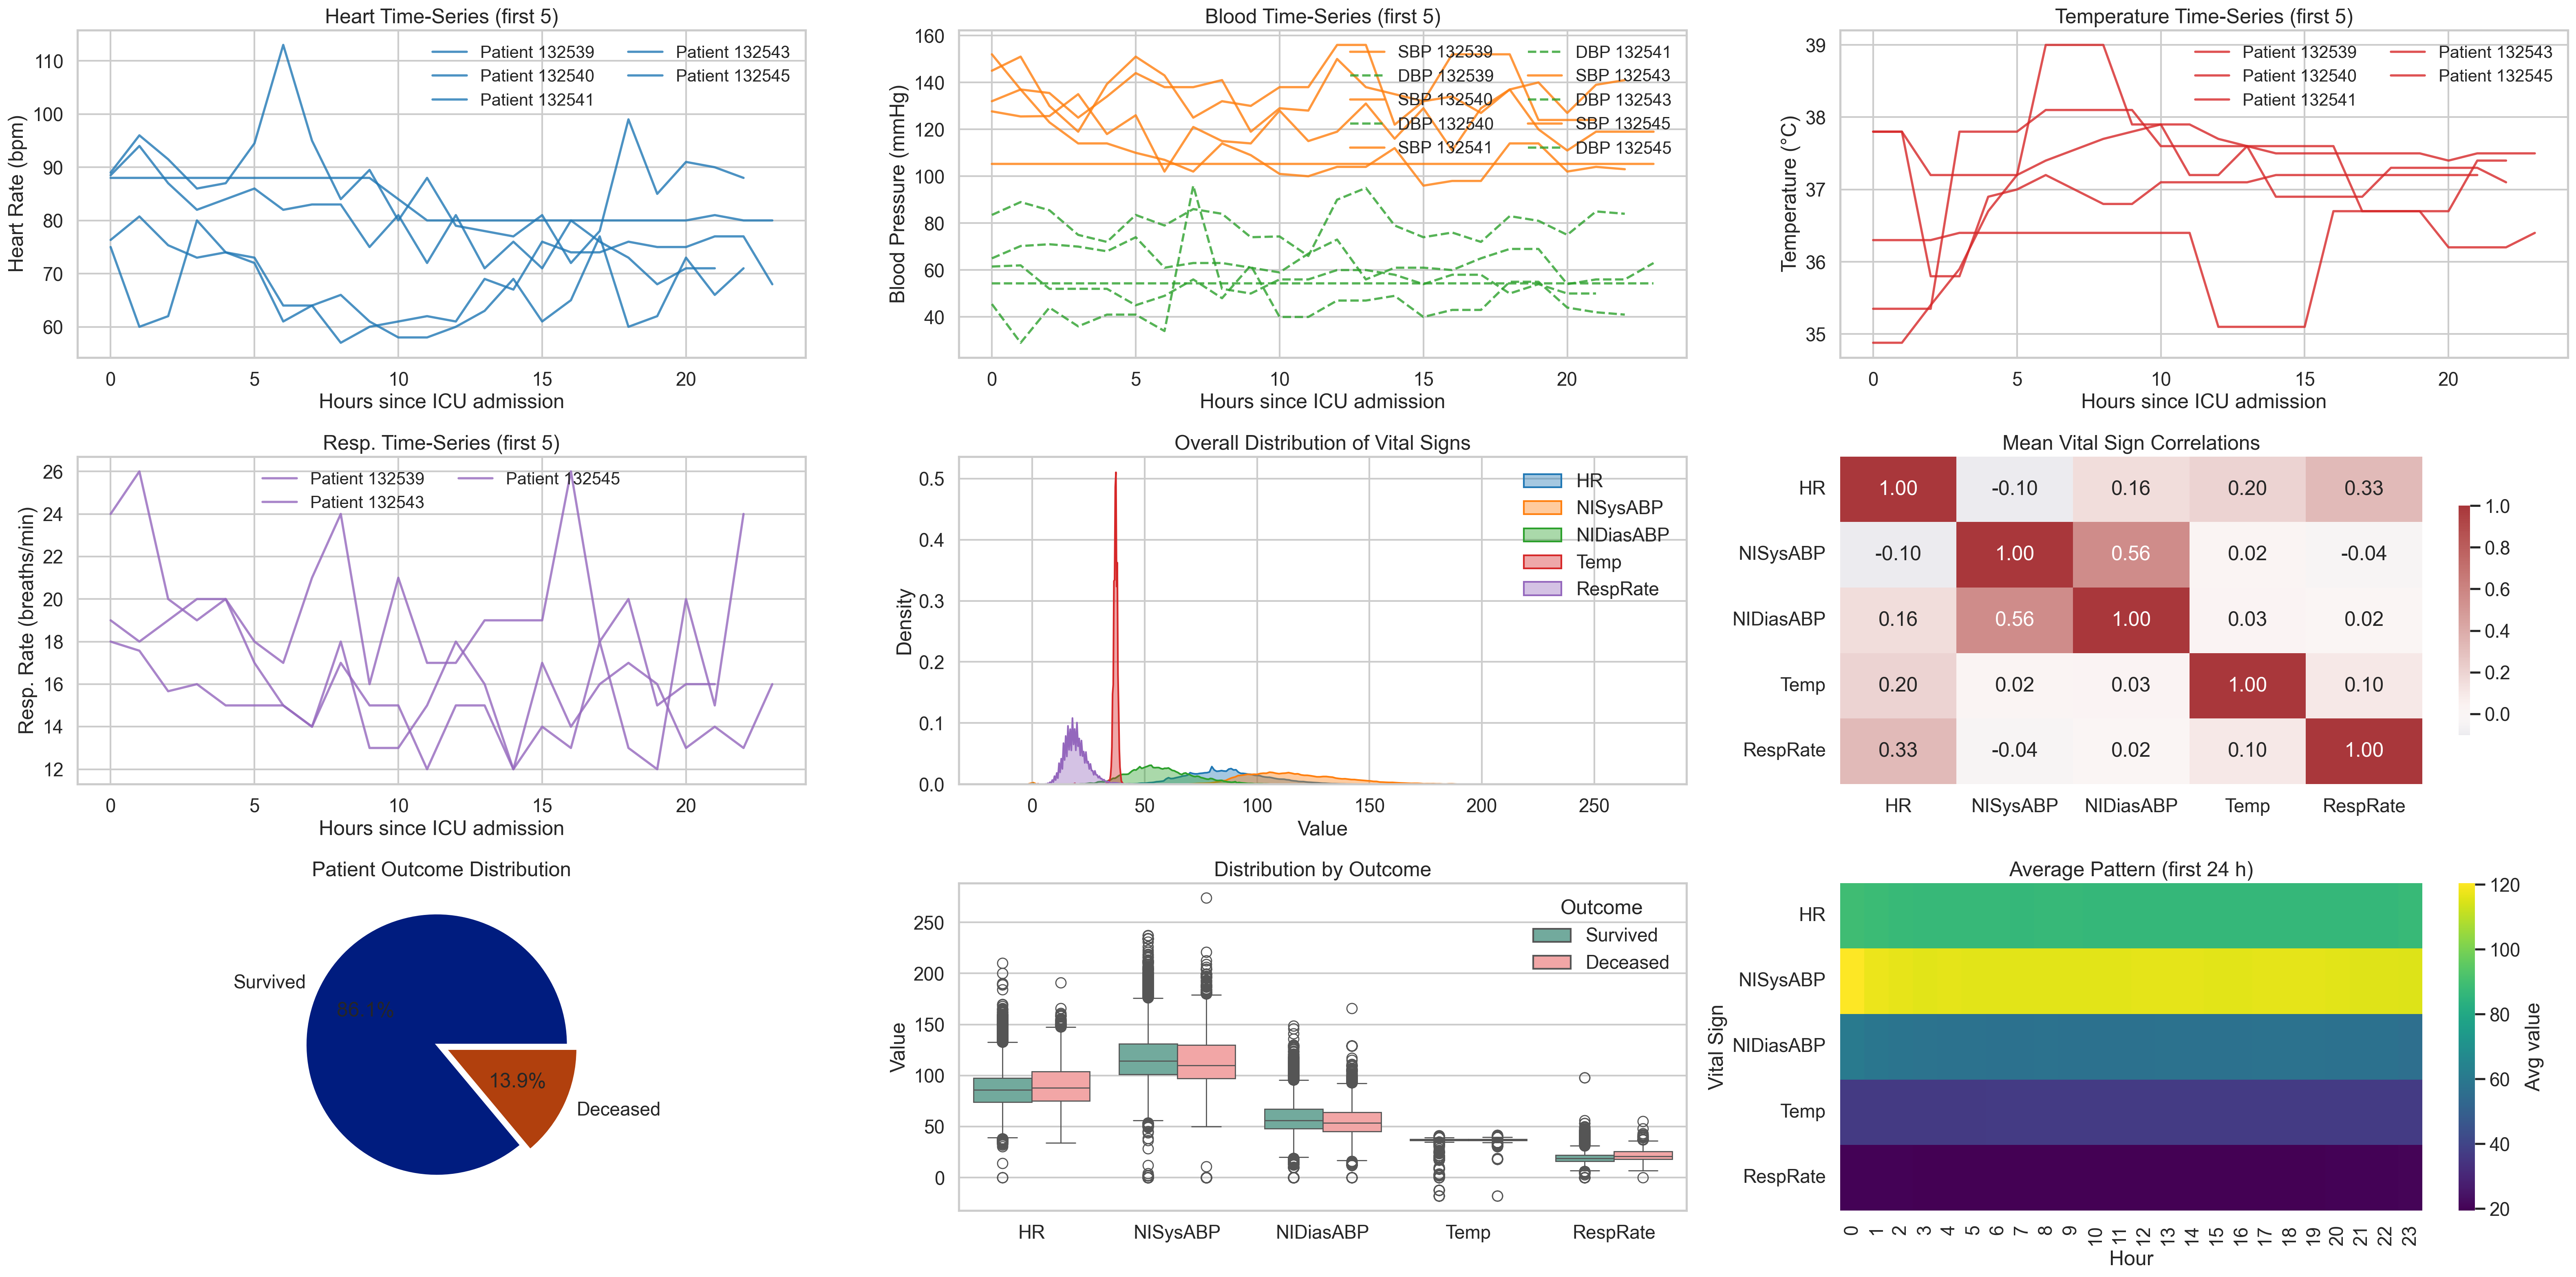


DATASET SUMMARY STATISTICS
Total number of patients: 3928
Number of patients with outcome data: 3928
Survival rate: 86.07%
Mortality rate: 13.93%

Vital Signs Summary:
HR: Mean=87.00, Std=18.13, Min=0.00, Max=210.00
NISysABP: Mean=116.29, Std=24.48, Min=0.00, Max=274.00
NIDiasABP: Mean=57.48, Std=15.19, Min=0.00, Max=166.00
Temp: Mean=36.92, Std=1.52, Min=-17.80, Max=41.50
RespRate: Mean=19.67, Std=5.51, Min=0.00, Max=98.00

Figure saved as 'physionet_overview.png'


In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

sns.set_theme(style="whitegrid", context="talk")         
plt.rcParams.update({"figure.dpi": 200})
PALETTE      = sns.color_palette("tab10")                 
VITAL_SIGNS  = ["HR", "NISysABP", "NIDiasABP", "Temp", "RespRate"]
SIGN_COLOUR  = dict(zip(VITAL_SIGNS, PALETTE))          
FIRST_N      = 5                                          

def _flatten(v):
    if isinstance(v, (list, np.ndarray)):
        return [x for x in np.ravel(v) if not np.isnan(x)]
    return [v] if pd.notna(v) else []

def _patient_series(df, pid, sign):
    s = df.loc[df.patient_id == pid, sign].values[0]
    return np.array(s) if isinstance(s, (list, np.ndarray)) else None

fig, axes = plt.subplots(3, 3, figsize=(32, 16))
axs = axes.ravel()          

timeplots = {
    0: ("HR",          "Heart Rate (bpm)"),
    1: (("NISysABP", "NIDiasABP"), "Blood Pressure (mmHg)"),
    2: ("Temp",        "Temperature (°C)"),
    3: ("RespRate",    "Resp. Rate (breaths/min)")
}
pids = df.patient_id.iloc[:FIRST_N]

for ax_idx, (signs, ylab) in timeplots.items():
    ax = axs[ax_idx]
    if isinstance(signs, tuple):                     
        for pid in pids:
            sbp = _patient_series(df, pid, signs[0])
            dbp = _patient_series(df, pid, signs[1])
            if sbp is not None:
                t = np.arange(len(sbp))
                ax.plot(t, sbp, lw=2, label=f"SBP {pid}",
                        color=SIGN_COLOUR[signs[0]], alpha=.8)
            if dbp is not None:
                t = np.arange(len(dbp))
                ax.plot(t, dbp, lw=2, ls="--", label=f"DBP {pid}",
                        color=SIGN_COLOUR[signs[1]], alpha=.8)
    else:                                             
        for pid in pids:
            ts = _patient_series(df, pid, signs)
            if ts is not None:
                ax.plot(np.arange(len(ts)), ts, lw=2,
                        label=f"Patient {pid}", alpha=.8,
                        color=SIGN_COLOUR[signs])
    ax.set_title(f"{ylab.split()[0]} Time-Series (first {FIRST_N})")
    ax.set_xlabel("Hours since ICU admission")
    ax.set_ylabel(ylab)
    ax.legend(fontsize="small", ncol=2)

ax = axs[4]
for sign in VITAL_SIGNS:
    vals = sum(df[sign].apply(_flatten).tolist(), [])
    sns.kdeplot(vals, ax=ax, label=sign,
                fill=True, bw_adjust=.3,
                color=SIGN_COLOUR[sign], alpha=.4)
ax.set_title("Overall Distribution of Vital Signs")
ax.set_xlabel("Value"); ax.set_ylabel("Density")
ax.legend()

ax = axs[5]
mean_vals = {
    sign: df[sign].apply(lambda s: np.nanmean(s) if isinstance(s, (list,np.ndarray)) else np.nan)
    for sign in VITAL_SIGNS
}
corr_df = pd.DataFrame(mean_vals)
sns.heatmap(corr_df.corr(), cmap="vlag", center=0,
            annot=True, fmt=".2f", ax=ax, cbar_kws=dict(shrink=.7))
ax.set_title("Mean Vital Sign Correlations")

ax = axs[6]
counts = df.outcome.value_counts().sort_index()
labels = counts.index.map({0:"Survived", 1:"Deceased"}).tolist()
ax.pie(counts, labels=labels, autopct="%1.1f%%",
       colors=sns.color_palette("dark", len(counts)), explode=[.04]*len(counts))
ax.set_title("Patient Outcome Distribution")

ax = axs[7]
melted = []
for sign in VITAL_SIGNS:
    for _, row in df.iterrows():
        values = _flatten(row[sign])
        for v in values:
            melted.append({"sign": sign,
                           "value": v,
                           "outcome": "Survived" if row.outcome == 0 else "Deceased"})
melt_df = pd.DataFrame(melted)
sns.boxplot(data=melt_df, x="sign", y="value", hue="outcome",
            palette=["#69b3a2", "#ff9999"], ax=ax)
ax.set_title("Distribution by Outcome")
ax.set_xlabel(""); ax.set_ylabel("Value")
ax.legend(title="Outcome")

ax = axs[8]
avg_mat = []
for sign in VITAL_SIGNS:
    series_list = df[sign].tolist()
    padded_series = []
    for series in series_list:
        if isinstance(series, (list, np.ndarray)):
            series = np.array(series)
            if len(series) < 24:
                padded = np.full(24, np.nan)
                padded[:len(series)] = series
                padded_series.append(padded)
            else:
                padded_series.append(series[:24])
    if padded_series:
        stacked = np.vstack(padded_series)
        avg_mat.append(np.nanmean(stacked, axis=0))
sns.heatmap(np.array(avg_mat), cmap="viridis",
            yticklabels=VITAL_SIGNS, ax=ax, cbar_kws=dict(label="Avg value"))
ax.set_title("Average Pattern (first 24 h)")
ax.set_xlabel("Hour"); ax.set_ylabel("Vital Sign")

plt.tight_layout()
plt.savefig("physionet_overview.png", bbox_inches="tight", facecolor="white")
plt.show()

print("\n" + "="*60)
print("DATASET SUMMARY STATISTICS")
print("="*60)
print(f"Total number of patients: {len(df)}")
print(f"Number of patients with outcome data: {len(df[df['outcome'].notna()])}")
print(f"Survival rate: {(df['outcome'] == 0).mean():.2%}")
print(f"Mortality rate: {(df['outcome'] == 1).mean():.2%}")

print("\nVital Signs Summary:")
for sign in VITAL_SIGNS:
    if sign in df.columns:
        all_values = []
        for _, row in df.iterrows():
            if isinstance(row[sign], (list, np.ndarray)):
                all_values.extend([v for v in row[sign] if not np.isnan(v)])
        if all_values:
            print(f"{sign}: Mean={np.mean(all_values):.2f}, Std={np.std(all_values):.2f}, "
                  f"Min={np.min(all_values):.2f}, Max={np.max(all_values):.2f}")

print(f"\nFigure saved as 'physionet_overview.png'")

## 5. Data Preparation

In [30]:
from sklearn.model_selection import StratifiedGroupKFold
import numpy as np

VITAL_SIGNS = ["HR", "NISysABP", "NIDiasABP", "Temp", "RespRate"]

def to_24(vec):
    if isinstance(vec, (list, np.ndarray)):
        vec = np.asarray(vec, dtype=float).flatten()
        if vec.size >= 24:
            return vec[:24]
        out = np.full(24, np.nan)
        out[:vec.size] = vec
        return out
    return np.full(24, np.nan)

for sign in VITAL_SIGNS:
    df[sign] = df[sign].apply(to_24)

mask_complete = df[VITAL_SIGNS].applymap(lambda v: np.isnan(v).any()).any(axis=1)
mask_labels = df["outcome"].isin([0, 1])

df_clean = df[~mask_complete & mask_labels].reset_index(drop=True)

print(df_clean["outcome"].value_counts(dropna=False))

X = np.stack([
        np.column_stack([row[sign] for sign in VITAL_SIGNS])
        for _, row in df_clean.iterrows()
    ])

y = df_clean["outcome"].values
groups = df_clean["patient_id"].astype(str).values

from sklearn.model_selection import StratifiedGroupKFold

outer = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
train_val_idx, test_idx = next(outer.split(X, y, groups))

X_train_val, X_test = X[train_val_idx], X[test_idx]
y_train_val, y_test = y[train_val_idx], y[test_idx]
groups_train_val = groups[train_val_idx]

inner = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
inner_train_idx, val_idx = next(
        inner.split(X_train_val, y_train_val, groups_train_val))

X_train, y_train = X_train_val[inner_train_idx], y_train_val[inner_train_idx]
X_val, y_val = X_train_val[val_idx], y_train_val[val_idx]

print(f"train : {X_train.shape} – positives {y_train.mean():.1%}")
print(f"val   : {X_val.shape}   – positives {y_val.mean():.1%}")
print(f"test  : {X_test.shape}  – positives {y_test.mean():.1%}")

outcome
0    337
1     37
Name: count, dtype: int64
train : (239, 24, 5) – positives 8.8%
val   : (60, 24, 5)   – positives 8.3%
test  : (75, 24, 5)  – positives 14.7%


C:\Users\Matt\AppData\Local\Temp\ipykernel_14604\2145197945.py:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mask_complete = df[VITAL_SIGNS].applymap(lambda v: np.isnan(v).any()).any(axis=1)


## 6. PyTorch Dataset and DataLoader

In [43]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from torch.utils.data.sampler import WeightedRandomSampler

class PatientDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()             # (N, 24, 5)
        self.y = torch.from_numpy(y.astype(np.float32))  # (N,)
    def __len__(self):  return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


train_ds = PatientDataset(X_train, y_train)
val_ds   = PatientDataset(X_val,   y_val)
test_ds  = PatientDataset(X_test,  y_test)

# optional: oversample the minority class inside every batch
class_count   = np.bincount(y_train)
class_weight  = 1. / class_count
sample_weight = class_weight[y_train]
sampler       = WeightedRandomSampler(sample_weight,
                                      num_samples=len(sample_weight),
                                      replacement=True)

train_loader = DataLoader(train_ds, batch_size=32, sampler=sampler,
                          num_workers=0, pin_memory=False, drop_last=True)
val_loader   = DataLoader(val_ds,   batch_size=64,
                          num_workers=0, pin_memory=False)
test_loader  = DataLoader(test_ds,  batch_size=64,
                          num_workers=0, pin_memory=False)

## 7. Defining an LSTM Model

In [60]:
import torch.nn as nn
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim=5, hidden_dim=128,
                 num_layers=1, dropout=0.0):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim,
                            num_layers=num_layers,
                            batch_first=True,
                            dropout=dropout)
        self.fc   = nn.Linear(hidden_dim, 1)            # logits

    def forward(self, x):                               # x: [B, 24, 5]
        _, (h_n, _) = self.lstm(x)                      # h_n: [L, B, H]
        logits = self.fc(h_n[-1])                       # last layer
        return logits.squeeze(1)    

## 8. Training Protocol

In [65]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LSTMClassifier().to(device)

# pos_weight = (# negatives) / (# positives)
pos_weight = torch.tensor( class_count[0] / class_count[1],
                           dtype=torch.float32).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def train_epoch(model, loader):
    model.train()
    running_loss = 0.
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss   = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
    return running_loss / len(loader.dataset)

def evaluate(model, loader):
    model.eval()
    running_loss = 0.
    all_preds, all_lbls = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss   = criterion(logits, yb)
            running_loss += loss.item() * xb.size(0)
            probs = torch.sigmoid(logits)              # convert to prob
            all_preds.extend(probs.cpu().numpy())
            all_lbls.extend(yb.cpu().numpy())
    return running_loss / len(loader.dataset), all_preds, all_lbls

## 9. Training the Model

Ep 01  train 2.8992  val 1.5264  AUC 0.265  lr 1.0e-03
Ep 02  train 1.8477  val 1.9532  AUC 0.436  lr 1.0e-03
Ep 03  train 1.6084  val 2.3752  AUC 0.611  lr 1.0e-03
Ep 04  train 1.5472  val 2.4169  AUC 0.789  lr 1.0e-03
Ep 05  train 1.4267  val 2.2878  AUC 0.862  lr 1.0e-03
Ep 06  train 1.4985  val 2.2719  AUC 0.836  lr 1.0e-03
Ep 07  train 1.4341  val 2.2251  AUC 0.840  lr 1.0e-03
Ep 08  train 1.4029  val 2.3022  AUC 0.807  lr 1.0e-03
Ep 09  train 1.4775  val 2.1465  AUC 0.818  lr 9.9e-04
Ep 10  train 1.4431  val 2.0944  AUC 0.825  lr 9.9e-04
Ep 11  train 1.4021  val 2.1618  AUC 0.782  lr 9.9e-04
Ep 12  train 1.3989  val 2.0707  AUC 0.844  lr 9.8e-04
Ep 13  train 1.3931  val 1.9871  AUC 0.793  lr 9.8e-04
Ep 14  train 1.3613  val 1.8923  AUC 0.796  lr 9.8e-04
Ep 15  train 1.4019  val 1.9246  AUC 0.742  lr 9.7e-04
Ep 16  train 1.3832  val 1.7757  AUC 0.778  lr 9.7e-04
Ep 17  train 1.2668  val 2.0327  AUC 0.829  lr 9.7e-04
Ep 18  train 1.3356  val 1.8760  AUC 0.829  lr 9.6e-04
Ep 19  tra

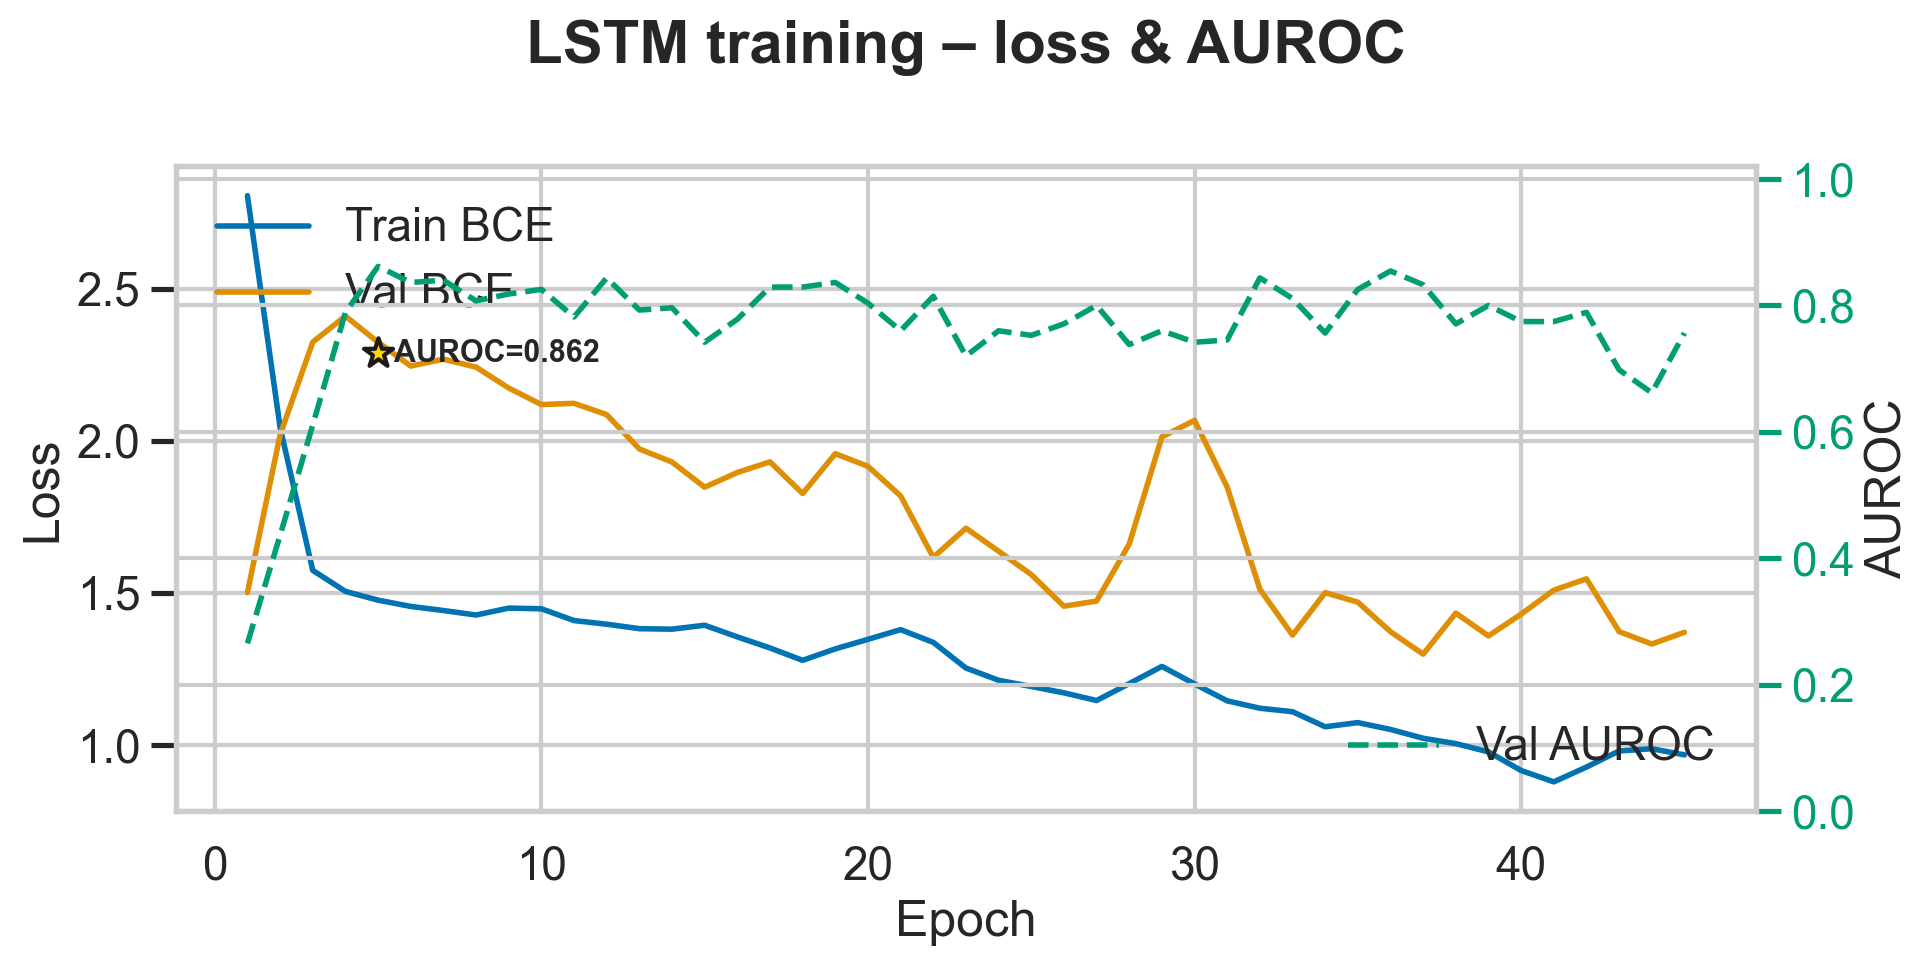

In [66]:
from sklearn.metrics import roc_auc_score
from collections import deque
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.signal import savgol_filter 

n_epochs     = 100
patience     = 40
best_val_auc = 0.
pat_queue    = deque(maxlen=patience)
scheduler    = torch.optim.lr_scheduler.ReduceLROnPlateau(
                    optimizer, mode='max', factor=0.99, patience=2)
history = {"train_loss": [], "val_loss": [], "val_auc": [],
           "lr": [], "best_epoch": None}

for epoch in range(1, n_epochs + 1):
    train_loss = train_epoch(model, train_loader)
    val_loss, val_pred, val_lbl = evaluate(model, val_loader)
    val_auc = roc_auc_score(val_lbl, val_pred)

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["val_auc"].append(val_auc)
    history["lr"].append(optimizer.param_groups[0]["lr"])

    if val_auc > best_val_auc:
        best_val_auc = val_auc
        history["best_epoch"] = epoch
        torch.save(model.state_dict(), "best_lstm.pt")

    print(f"Ep {epoch:02d}  train {train_loss:.4f}  "
          f"val {val_loss:.4f}  AUC {val_auc:.3f}  "
          f"lr {optimizer.param_groups[0]['lr']:.1e}")

    scheduler.step(val_auc)
    pat_queue.append(val_auc < best_val_auc)
    if all(pat_queue):
        print(f"Early stopping after {epoch} epochs.")
        break

sns.set_theme(style="whitegrid", context="talk")
palette = sns.color_palette("colorblind")

epochs = np.arange(1, len(history["train_loss"]) + 1)

fig, ax1 = plt.subplots(figsize=(10, 5))

# smooth loss curves only if ≥5 points
def smooth(y):
    return savgol_filter(y, 5, polyorder=2) if len(y) >= 5 else y

ax1.plot(epochs, smooth(history["train_loss"]),
         label="Train BCE", color=palette[0], lw=2)
ax1.plot(epochs, smooth(history["val_loss"]),
         label="Val BCE",   color=palette[1], lw=2)
ax1.set_xlabel("Epoch");  ax1.set_ylabel("Loss")
ax1.legend(loc="upper left")

# AUROC on twin axis
ax2 = ax1.twinx()
ax2.plot(epochs, history["val_auc"], label="Val AUROC",
         color=palette[2], lw=2, ls="--")
ax2.set_ylabel("AUROC");  ax2.set_ylim(0, 1.02)
ax2.tick_params(axis="y", colors=palette[2])
ax2.legend(loc="lower right")

# mark best epoch
be = history["best_epoch"]
ax1.scatter(be, history["val_loss"][be-1],
            s=120, marker="*", color="gold", edgecolor="k", zorder=3)
ax1.text(be, history["val_loss"][be-1],
         f"  AUROC={history['val_auc'][be-1]:.3f}",
         fontsize=11, weight="bold", va="center", ha="left")

fig.suptitle("LSTM training – loss & AUROC", weight="bold")
fig.tight_layout()
plt.show()

## 10. Model Evaluation

Test   AUROC = 0.703
Test   AUPRC = 0.334
Chosen threshold (max Youden J) = 0.922
Accuracy  = 0.693
F1-score  = 0.439
Sensitivity (recall⁺) = 0.818
Specificity           = 0.672


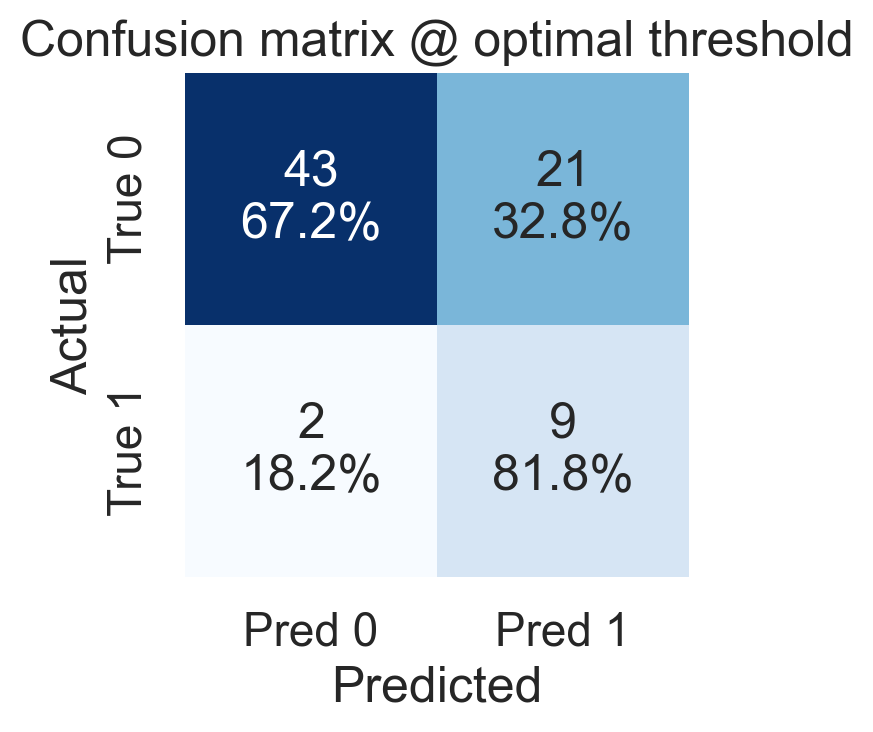

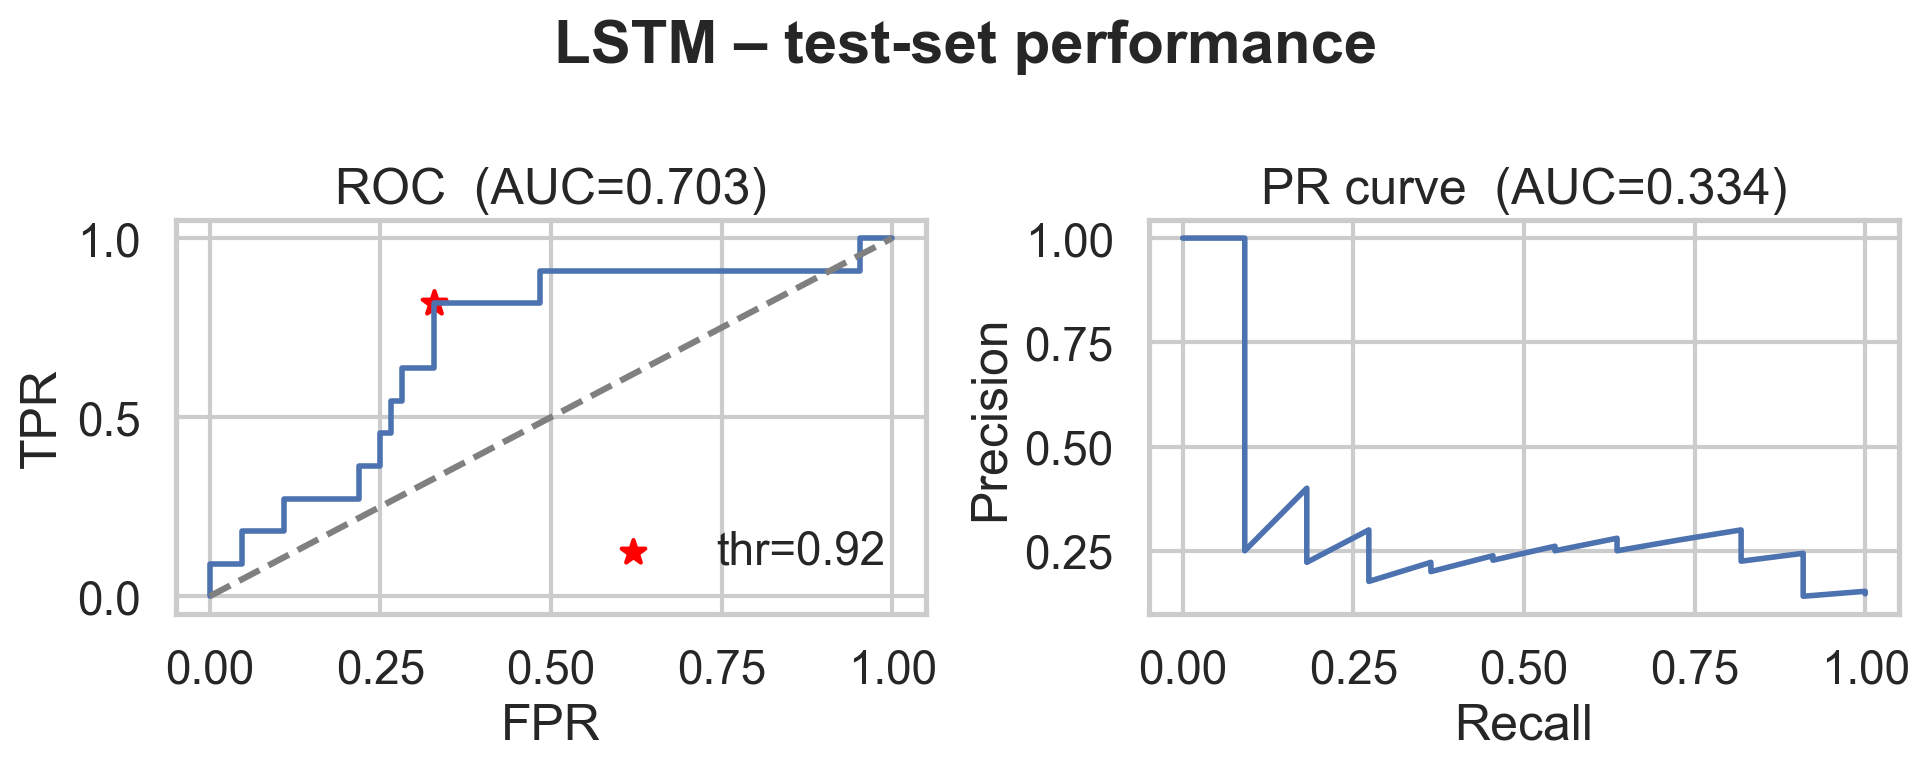

In [68]:
from sklearn.metrics import (roc_auc_score, average_precision_score,
                             precision_recall_curve, roc_curve,
                             f1_score, confusion_matrix, classification_report)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch, pathlib, textwrap


model.load_state_dict(torch.load("best_lstm.pt"))
model.eval()

all_logits, all_labels = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        logits = model(xb)
        all_logits.extend(logits.cpu().numpy())
        all_labels.extend(yb.numpy())

all_logits  = np.array(all_logits)
all_probs   = torch.sigmoid(torch.tensor(all_logits)).numpy()
all_labels  = np.array(all_labels, dtype=int)

roc_auc  = roc_auc_score(all_labels, all_probs)
pr_auc   = average_precision_score(all_labels, all_probs)
print(f"Test   AUROC = {roc_auc:.3f}")
print(f"Test   AUPRC = {pr_auc:.3f}")

fpr, tpr, roc_th = roc_curve(all_labels, all_probs)
j_scores = tpr - fpr
best_idx = j_scores.argmax()
best_thr = roc_th[best_idx]

print(f"Chosen threshold (max Youden J) = {best_thr:.3f}")

pred_bin = (all_probs >= best_thr).astype(int)

acc  = (pred_bin == all_labels).mean()
f1   = f1_score(all_labels, pred_bin)
sens = tpr[best_idx]                   
spec = 1 - fpr[best_idx]

print(f"Accuracy  = {acc:.3f}")
print(f"F1-score  = {f1:.3f}")
print(f"Sensitivity (recall⁺) = {sens:.3f}")
print(f"Specificity           = {spec:.3f}")

cm = confusion_matrix(all_labels, pred_bin)
cm_pct = cm / cm.sum(axis=1, keepdims=True) * 100

labels = np.array([[f"{n}\n{p:.1f}%" for n, p in zip(row_cnt, row_pct)]
                   for row_cnt, row_pct in zip(cm, cm_pct)])

sns.set_theme(style="whitegrid", context="talk")
fig, ax = plt.subplots(figsize=(4, 4))
sns.heatmap(cm, annot=labels, fmt="", cmap="Blues",
            cbar=False, square=True, ax=ax,
            xticklabels=["Pred 0", "Pred 1"],
            yticklabels=["True 0", "True 1"])
ax.set_xlabel("Predicted"); ax.set_ylabel("Actual")
ax.set_title("Confusion matrix @ optimal threshold")
fig.tight_layout()
plt.show()

fig, (ax_roc, ax_pr) = plt.subplots(1, 2, figsize=(10, 4))

ax_roc.plot(fpr, tpr, lw=2)
ax_roc.scatter(fpr[best_idx], tpr[best_idx], s=80,
               marker="*", color="red", label=f"thr={best_thr:.2f}")
ax_roc.plot([0,1],[0,1],'--',color='gray')
ax_roc.set_xlabel("FPR"); ax_roc.set_ylabel("TPR")
ax_roc.set_title(f"ROC  (AUC={roc_auc:.3f})")
ax_roc.legend()

prec, rec, _ = precision_recall_curve(all_labels, all_probs)
ax_pr.plot(rec, prec, lw=2)
ax_pr.set_xlabel("Recall"); ax_pr.set_ylabel("Precision")
ax_pr.set_title(f"PR curve  (AUC={pr_auc:.3f})")

fig.suptitle("LSTM – test-set performance", weight="bold")
fig.tight_layout()
plt.show()

## 11. Adding Attention to the LSTM

C:\Users\Matt\AppData\Local\Temp\ipykernel_14604\3566186179.py:73: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=device.type == "cuda")  # mixed precision
C:\Users\Matt\AppData\Local\Temp\ipykernel_14604\3566186179.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type == "cuda"):
C:\Users\Matt\AppData\Local\Temp\ipykernel_14604\3566186179.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type == "cuda"):


Ep 01 | train 2.3286 | val 2.8179 | AUC 0.684 | lr 1.0e-03
Ep 02 | train 1.5941 | val 2.3835 | AUC 0.742 | lr 1.0e-03


C:\Users\Matt\AppData\Local\Temp\ipykernel_14604\3566186179.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type == "cuda"):
C:\Users\Matt\AppData\Local\Temp\ipykernel_14604\3566186179.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type == "cuda"):


Ep 03 | train 1.6002 | val 1.7557 | AUC 0.804 | lr 1.0e-03
Ep 04 | train 1.5279 | val 1.9161 | AUC 0.818 | lr 1.0e-03


C:\Users\Matt\AppData\Local\Temp\ipykernel_14604\3566186179.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type == "cuda"):
C:\Users\Matt\AppData\Local\Temp\ipykernel_14604\3566186179.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type == "cuda"):


Ep 05 | train 1.4725 | val 2.2620 | AUC 0.865 | lr 1.0e-03
Ep 06 | train 1.4583 | val 1.7856 | AUC 0.865 | lr 1.0e-03


C:\Users\Matt\AppData\Local\Temp\ipykernel_14604\3566186179.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type == "cuda"):
C:\Users\Matt\AppData\Local\Temp\ipykernel_14604\3566186179.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type == "cuda"):


Ep 07 | train 1.3415 | val 1.7013 | AUC 0.836 | lr 1.0e-03
Ep 08 | train 1.3203 | val 1.8426 | AUC 0.851 | lr 1.0e-03


C:\Users\Matt\AppData\Local\Temp\ipykernel_14604\3566186179.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type == "cuda"):
C:\Users\Matt\AppData\Local\Temp\ipykernel_14604\3566186179.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type == "cuda"):


Ep 09 | train 1.2876 | val 1.4942 | AUC 0.855 | lr 1.0e-03
Ep 10 | train 1.1203 | val 1.5286 | AUC 0.847 | lr 5.0e-04


C:\Users\Matt\AppData\Local\Temp\ipykernel_14604\3566186179.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type == "cuda"):
C:\Users\Matt\AppData\Local\Temp\ipykernel_14604\3566186179.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type == "cuda"):


Ep 11 | train 1.1780 | val 1.4914 | AUC 0.876 | lr 5.0e-04
Ep 12 | train 1.2737 | val 1.3479 | AUC 0.884 | lr 5.0e-04


C:\Users\Matt\AppData\Local\Temp\ipykernel_14604\3566186179.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type == "cuda"):
C:\Users\Matt\AppData\Local\Temp\ipykernel_14604\3566186179.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type == "cuda"):


Ep 13 | train 1.1707 | val 1.1420 | AUC 0.873 | lr 5.0e-04
Ep 14 | train 1.0758 | val 1.7338 | AUC 0.847 | lr 5.0e-04


C:\Users\Matt\AppData\Local\Temp\ipykernel_14604\3566186179.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type == "cuda"):
C:\Users\Matt\AppData\Local\Temp\ipykernel_14604\3566186179.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type == "cuda"):


Ep 15 | train 1.3389 | val 1.7864 | AUC 0.847 | lr 5.0e-04
Ep 16 | train 1.7101 | val 0.8721 | AUC 0.876 | lr 5.0e-04


C:\Users\Matt\AppData\Local\Temp\ipykernel_14604\3566186179.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type == "cuda"):
C:\Users\Matt\AppData\Local\Temp\ipykernel_14604\3566186179.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type == "cuda"):


Ep 17 | train 1.5848 | val 1.1463 | AUC 0.873 | lr 2.5e-04
Ep 18 | train 1.0382 | val 1.8939 | AUC 0.851 | lr 2.5e-04


C:\Users\Matt\AppData\Local\Temp\ipykernel_14604\3566186179.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type == "cuda"):
C:\Users\Matt\AppData\Local\Temp\ipykernel_14604\3566186179.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type == "cuda"):


Ep 19 | train 1.2641 | val 1.6465 | AUC 0.858 | lr 2.5e-04
Ep 20 | train 1.0827 | val 1.0489 | AUC 0.887 | lr 2.5e-04


C:\Users\Matt\AppData\Local\Temp\ipykernel_14604\3566186179.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type == "cuda"):
C:\Users\Matt\AppData\Local\Temp\ipykernel_14604\3566186179.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type == "cuda"):


Ep 21 | train 1.1621 | val 1.0771 | AUC 0.865 | lr 2.5e-04
Ep 22 | train 1.0570 | val 1.3815 | AUC 0.851 | lr 2.5e-04


C:\Users\Matt\AppData\Local\Temp\ipykernel_14604\3566186179.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type == "cuda"):
C:\Users\Matt\AppData\Local\Temp\ipykernel_14604\3566186179.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type == "cuda"):


Ep 23 | train 1.0666 | val 1.0723 | AUC 0.880 | lr 2.5e-04
Ep 24 | train 1.0951 | val 1.2071 | AUC 0.876 | lr 2.5e-04


C:\Users\Matt\AppData\Local\Temp\ipykernel_14604\3566186179.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type == "cuda"):
C:\Users\Matt\AppData\Local\Temp\ipykernel_14604\3566186179.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type == "cuda"):


Ep 25 | train 0.9814 | val 1.2525 | AUC 0.876 | lr 1.3e-04
Ep 26 | train 0.8881 | val 1.2441 | AUC 0.887 | lr 1.3e-04


C:\Users\Matt\AppData\Local\Temp\ipykernel_14604\3566186179.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type == "cuda"):
C:\Users\Matt\AppData\Local\Temp\ipykernel_14604\3566186179.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type == "cuda"):


Ep 27 | train 1.0252 | val 1.1412 | AUC 0.895 | lr 1.3e-04
Ep 28 | train 0.9964 | val 1.1524 | AUC 0.887 | lr 1.3e-04


C:\Users\Matt\AppData\Local\Temp\ipykernel_14604\3566186179.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type == "cuda"):
C:\Users\Matt\AppData\Local\Temp\ipykernel_14604\3566186179.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type == "cuda"):


Ep 29 | train 0.9308 | val 1.1171 | AUC 0.898 | lr 1.3e-04
Ep 30 | train 0.9103 | val 1.0168 | AUC 0.905 | lr 1.3e-04


C:\Users\Matt\AppData\Local\Temp\ipykernel_14604\3566186179.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type == "cuda"):
C:\Users\Matt\AppData\Local\Temp\ipykernel_14604\3566186179.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type == "cuda"):


Ep 31 | train 0.9400 | val 1.1677 | AUC 0.891 | lr 1.3e-04
Ep 32 | train 0.8818 | val 0.9857 | AUC 0.898 | lr 1.3e-04


C:\Users\Matt\AppData\Local\Temp\ipykernel_14604\3566186179.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type == "cuda"):
C:\Users\Matt\AppData\Local\Temp\ipykernel_14604\3566186179.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type == "cuda"):


Ep 33 | train 0.7523 | val 1.0765 | AUC 0.887 | lr 1.3e-04
Ep 34 | train 0.8585 | val 1.1199 | AUC 0.887 | lr 1.3e-04


C:\Users\Matt\AppData\Local\Temp\ipykernel_14604\3566186179.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type == "cuda"):
C:\Users\Matt\AppData\Local\Temp\ipykernel_14604\3566186179.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type == "cuda"):


Ep 35 | train 0.8253 | val 1.0099 | AUC 0.895 | lr 6.3e-05
Ep 36 | train 0.6251 | val 0.9890 | AUC 0.895 | lr 6.3e-05


C:\Users\Matt\AppData\Local\Temp\ipykernel_14604\3566186179.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type == "cuda"):
C:\Users\Matt\AppData\Local\Temp\ipykernel_14604\3566186179.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type == "cuda"):


Ep 37 | train 0.7081 | val 0.9936 | AUC 0.891 | lr 6.3e-05
Ep 38 | train 0.7088 | val 1.0115 | AUC 0.887 | lr 6.3e-05


C:\Users\Matt\AppData\Local\Temp\ipykernel_14604\3566186179.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type == "cuda"):
C:\Users\Matt\AppData\Local\Temp\ipykernel_14604\3566186179.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type == "cuda"):


Ep 39 | train 0.7666 | val 0.9830 | AUC 0.887 | lr 3.1e-05
Ep 40 | train 0.6460 | val 0.9852 | AUC 0.887 | lr 3.1e-05


C:\Users\Matt\AppData\Local\Temp\ipykernel_14604\3566186179.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type == "cuda"):
C:\Users\Matt\AppData\Local\Temp\ipykernel_14604\3566186179.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type == "cuda"):


Ep 41 | train 0.6110 | val 1.0015 | AUC 0.884 | lr 3.1e-05
Ep 42 | train 0.5405 | val 0.9639 | AUC 0.891 | lr 3.1e-05


C:\Users\Matt\AppData\Local\Temp\ipykernel_14604\3566186179.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type == "cuda"):
C:\Users\Matt\AppData\Local\Temp\ipykernel_14604\3566186179.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type == "cuda"):


Ep 43 | train 0.7347 | val 0.9329 | AUC 0.891 | lr 1.6e-05
Ep 44 | train 0.9334 | val 0.9275 | AUC 0.887 | lr 1.6e-05


C:\Users\Matt\AppData\Local\Temp\ipykernel_14604\3566186179.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type == "cuda"):


Ep 45 | train 0.6597 | val 0.9522 | AUC 0.887 | lr 1.6e-05
Early-stopping @ epoch 45


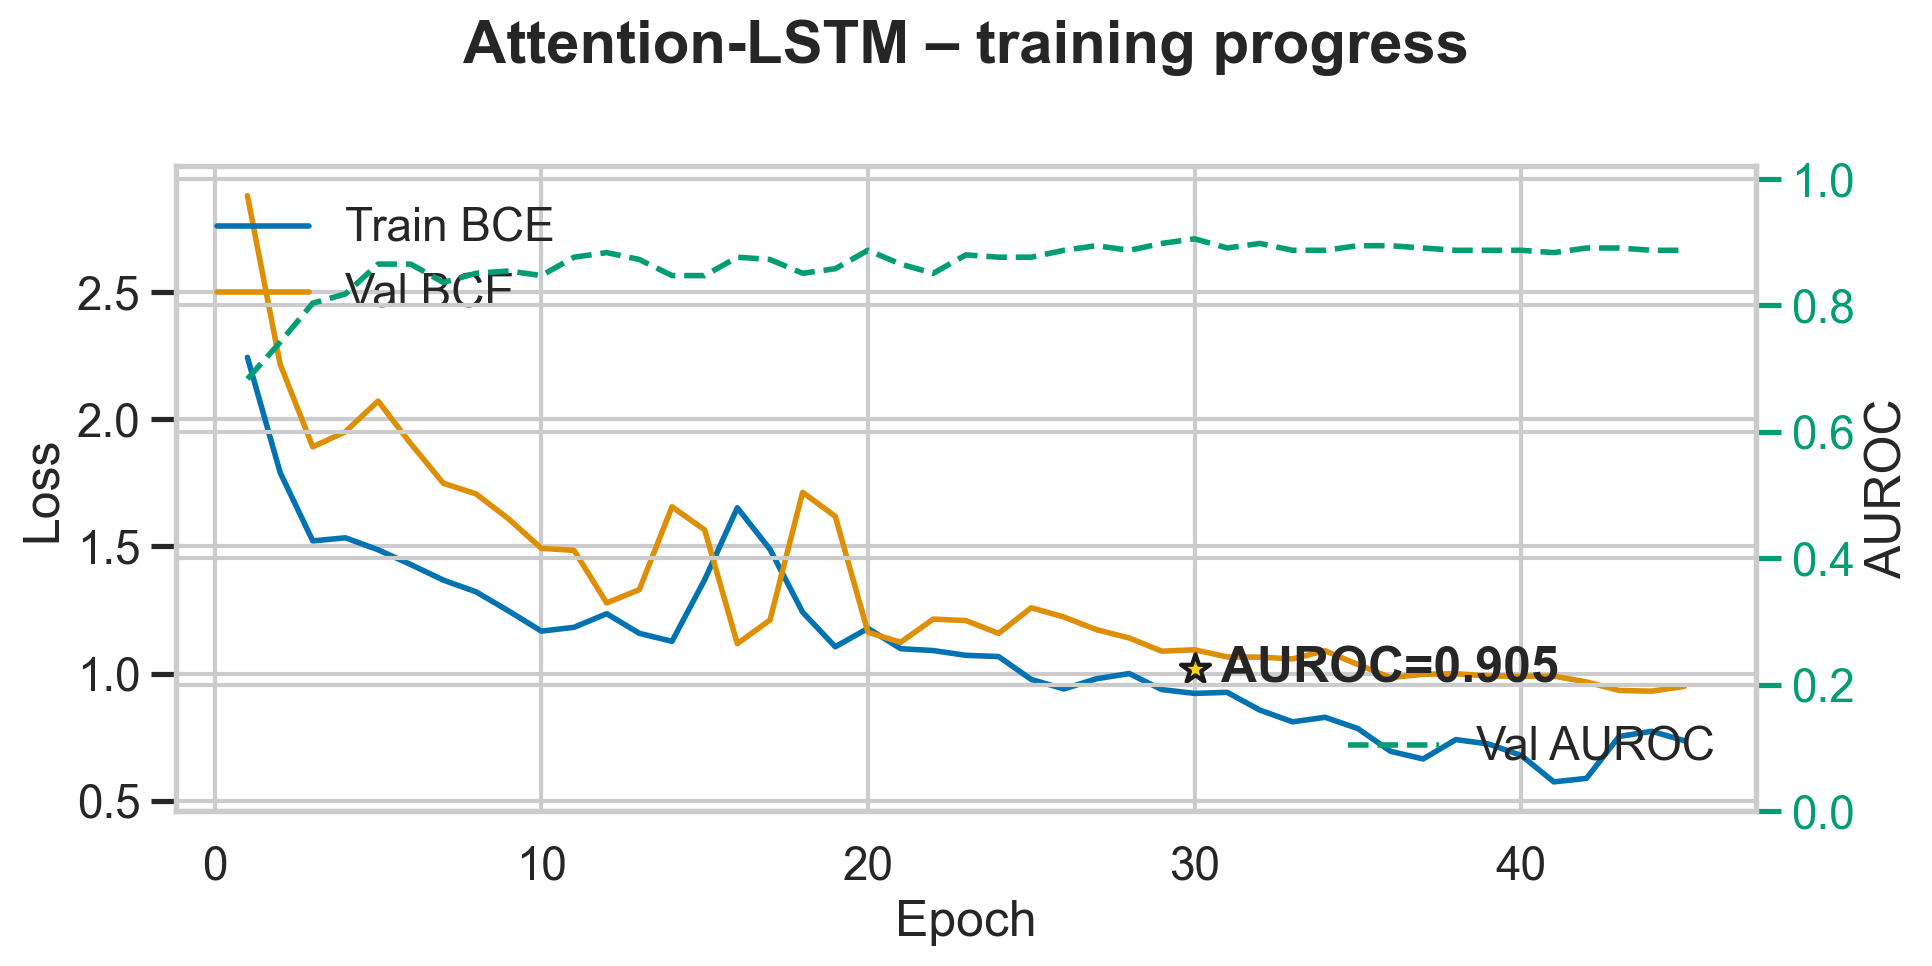

In [72]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AttentionLSTMClassifier(nn.Module):
    """
    Sequence-level binary classifier with additive attention.

    Parameters
    ----------
    input_dim : int   # features per time step (5 for HR, SBP, DBP, Temp, RR)
    hidden_dim: int   # LSTM hidden size
    num_layers: int   # stacked LSTM layers
    dropout    float  # dropout applied *between* LSTM layers
    bidirectional: bool  # if True → Bi-LSTM
    """
    def __init__(self,
                 input_dim: int = 5,
                 hidden_dim: int = 128,
                 num_layers: int = 1,
                 dropout: float = 0.1,
                 bidirectional: bool = False):
        super().__init__()

        self.lstm = nn.LSTM(input_dim,
                            hidden_dim,
                            num_layers=num_layers,
                            batch_first=True,
                            dropout=dropout if num_layers > 1 else 0.,
                            bidirectional=bidirectional)

        self.directions = 2 if bidirectional else 1
        attn_dim = hidden_dim * self.directions

        # single-head "dot" attention → score = wᵀ · h_t
        self.attn_score = nn.Linear(attn_dim, 1, bias=False)
        self.fc = nn.Linear(attn_dim, 1)          # logits → BCEWithLogitsLoss

    def forward(self, x, mask=None):
        """
        x : FloatTensor [B, T, F]     (batch_first=True)
        mask : BoolTensor  [B, T]     True where *valid*; optional
        Returns
        -------
        logits  FloatTensor [B]
        α       FloatTensor [B, T]    attention weights (sum=1)
        """
        h_seq, _ = self.lstm(x)                  # h_seq : [B, T, H*dir]

        # (Optional) replace NaN / pad positions by −inf before softmax
        e = self.attn_score(h_seq).squeeze(-1)    # [B, T]

        if mask is not None:
            e = e.masked_fill(~mask, float("-inf"))

        α = torch.softmax(e, dim=1)              # [B, T]

        # context = Σ α_t · h_t
        context = torch.bmm(α.unsqueeze(1), h_seq).squeeze(1)  # [B, H*dir]

        logits = self.fc(context).squeeze(1)     # [B]
        return logits, α
    
model = AttentionLSTMClassifier(input_dim=5,
                            hidden_dim=128,
                            num_layers=2,
                            dropout=0.2,
                            bidirectional=True).to(device)

criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)

scaler = torch.cuda.amp.GradScaler(enabled=device.type == "cuda")  # mixed precision

def train_epoch(model, loader):
    model.train()
    running = 0.0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()

        with torch.cuda.amp.autocast(enabled=device.type == "cuda"):
            logits, _ = model(xb)          # ignore α during training
            loss = criterion(logits, yb)

        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer); scaler.update()

        running += loss.item() * xb.size(0)
    return running / len(loader.dataset)

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    running, preds, lbls = 0.0, [], []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        logits, _ = model(xb)
        loss = criterion(logits, yb)

        running += loss.item() * xb.size(0)
        preds.extend(torch.sigmoid(logits).cpu().numpy())
        lbls.extend(yb.cpu().numpy())
    return running / len(loader.dataset), np.array(preds), np.array(lbls)

n_epochs  = 100
patience  = 15                 # early-stop patience in epochs

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode="max", factor=0.5, patience=3)
hist = {"train": [], "val": [], "auc": [], "lr": [], "best_ep": 0}
best_auc, bad_epochs = 0., 0

for ep in range(1, n_epochs + 1):
    tr_loss = train_epoch(model, train_loader)
    vl_loss, vl_pred, vl_lbl = evaluate(model, val_loader)
    vl_auc  = roc_auc_score(vl_lbl, vl_pred)

    hist["train"].append(tr_loss)
    hist["val"].append(vl_loss)
    hist["auc"].append(vl_auc)
    hist["lr"].append(optimizer.param_groups[0]["lr"])

    print(f"Ep {ep:02d} | train {tr_loss:.4f} | val {vl_loss:.4f} "
          f"| AUC {vl_auc:.3f} | lr {hist['lr'][-1]:.1e}")

    scheduler.step(vl_auc)

    if vl_auc > best_auc:
        best_auc, bad_epochs = vl_auc, 0
        hist["best_ep"] = ep
        torch.save(model.state_dict(), "best_attn_lstm.pt")
    else:
        bad_epochs += 1
        if bad_epochs >= patience:
            print(f"Early-stopping @ epoch {ep}")
            break
sns.set_theme(style="whitegrid", context="talk")
pal = sns.color_palette("colorblind")

ep = np.arange(1, len(hist["train"]) + 1)

fig, ax1 = plt.subplots(figsize=(10, 5))

def smooth(v):                 # Savitzky-Golay if ≥5 pts
    return savgol_filter(v, 5, 2) if len(v) >= 5 else v

ax1.plot(ep, smooth(hist["train"]), label="Train BCE",
         color=pal[0], lw=2)
ax1.plot(ep, smooth(hist["val"]),   label="Val BCE",
         color=pal[1], lw=2)
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend(loc="upper left")

ax2 = ax1.twinx()
ax2.plot(ep, hist["auc"], label="Val AUROC",
         color=pal[2], lw=2, ls="--")
ax2.set_ylabel("AUROC"); ax2.set_ylim(0, 1.02)
ax2.tick_params(axis="y", colors=pal[2])
ax2.legend(loc="lower right")

be = hist["best_ep"]
ax1.scatter(be, hist["val"][be-1], s=120, marker="*",
            color="gold", edgecolor="k", zorder=3)
ax1.text(be, hist["val"][be-1],
         f"  AUROC={hist['auc'][be-1]:.3f}",
         weight="bold", va="center", ha="left")

fig.suptitle("Attention-LSTM – training progress", weight="bold")
fig.tight_layout(); plt.show()
